# Alzheimer's disease dataset analysis and comparison

Comparing gene sets thought to be compromised in Alzheimer's disease patients. 

In [1]:
# Importing packages
from matplotlib import pyplot as plt
import seaborn as sns  # for nicer graphics
import pandas as pd
import numpy as np
import random
import string
import csv

# Permuting samples
Here, we obtain the intersection of genes between 'AD_UPenn_prot', 'AD_Banner_prot', and gene set thought to be compromise in Alzheimer's patients --- this intersection excludes genes with an associated value of 0 or NaN. After obtaining this intersection, we calculate the euclidean distance of the covariance matrix to obtain a 'true' distance value. This distance calculation is repeated after permuting samples. Permuting here means we concatenate all samples from both datasets, and randomly distribute these samples to the original datasets --- we make sure that the number of samples in each dataset is equal before and after shuffling. For example, if ds1 and ds2 originall had 24 and 225 samples, respetively, that's how many samples they will received after the permutation procedure. NOTE: sample permutation is only done on the genes found in the intersect.

Gene set obtained from: MSigDB (http://software.broadinstitute.org/gsea/msigdb/collections.jsp)

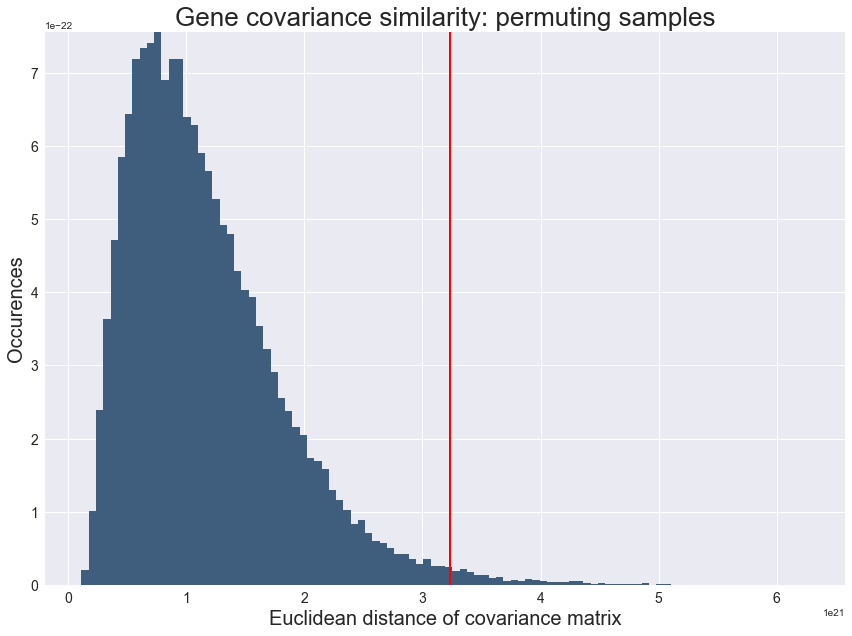

z-score for euclidean distance of non-permuted samples:  3.1082471043184086


In [6]:
dist_cov_euclidean_permute_samples('GO_REGULATION_OF_SYNAPTIC_PLASTICITY.csv', 'AD_Upenn_prot.txt', 'AD_Banner_prot.txt',50000)

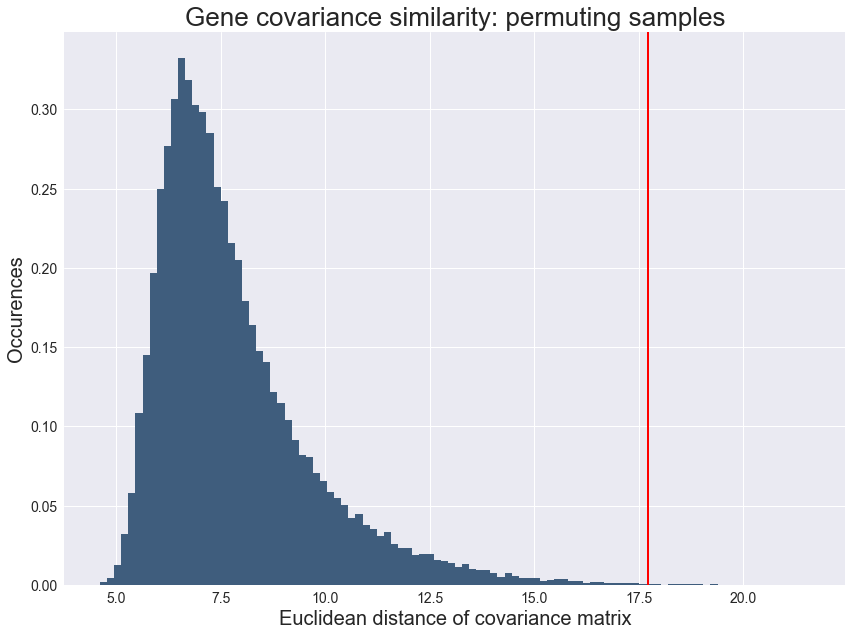

z-score for euclidean distance of non-permuted samples:  5.26268729269915


In [43]:
dist_spear_euclidean_permute_samples('GO_REGULATION_OF_SYNAPTIC_PLASTICITY.csv', 'AD_Upenn_prot.txt', 'AD_Banner_prot.txt',50000)

In [5]:
# Function permutes samples and computes euclidean distance distribution of covariance matrix
# This only permutes genes that were found in intersection of the comparison gene set and both datasets

# comparison_genes: gene set list we want to compare our actual datasets to 
    ## since we are permuting samples anyways, this is only used to create a "True" euclidean distance value that we would 
    ## obtain had no samples been permuted
# dataset1 : samples x gene dataset. should be in txt format

# dataset2: samples x gene dataset. should be in txt format

# permute_number: number of times we want to permute samples (excluding first run without permutations). 
        ## note that the first run is done without any permutations and by taking the intersection of dataset and the 
        ## comparison_genes set

def dist_cov_euclidean_permute_samples(comparison_genes, dataset1, dataset2, permute_number):
    
    # list where shuffled euclidean distances will be added
    euclidean_distances_shuffle_samples = []
     
    # placing datasets into a dataframe
    dataset1_df = pd.read_table(dataset1,index_col=0)  # first dataset for comparison
    dataset2_df = pd.read_table(dataset2,index_col=0)  # second dataset for comparison
    
    # placing comparison genes into a list of lists (just the way it's read in) -- assumes .csv format 
    with open(comparison_genes, 'r') as f:
        reader = csv.reader(f)
        gene_list_raw = list(reader)
            
    # placing genes into a list
    gene_list_original = []
    for gene in gene_list_raw:
        gene_list_original.append(gene[0])
        
    # list where euclidean distances will be stored
    euclidean_distances_genes_permute = []
    
    # getting rid of columns with NaN or 0 values -- essentially just replacing 0 -> NaN and getting rid of NaN values
    dataset1_gene_list = list(dataset1_df.replace(0,pd.np.nan).dropna(axis='columns').columns.values)
    dataset2_gene_list = list(dataset2_df.replace(0,pd.np.nan).dropna(axis='columns').columns.values)

    # taking intersection of lists
    gene_set = list(set(gene_list_original).intersection(dataset1_gene_list, dataset2_gene_list))

    # Recreating dataframes with only genes from intersection
    dataset1_intersect_df = dataset1_df[gene_set]
    dataset2_intersect_df = dataset2_df[gene_set]

    # concatenating dataframes so we can randomly sample from whole pool
    datasets_concat_frames = [dataset1_intersect_df, dataset2_intersect_df] 
    datasets_concat_df = pd.concat(datasets_concat_frames)
    
    # Counting number of samples that must go into every dataset
    number_samples_ds1 = dataset1_intersect_df.shape[0]
    number_samples_ds2 = dataset2_intersect_df.shape[0]
    number_samples_tot = number_samples_ds1 + number_samples_ds2

    # loop that shuffles samples and calculates euclidean distances - first run will analyze non-permuted samples
    for index in range(0,permute_number+1):

        # shuffling samples -- making sure right number gets allotted in correct order
        # At this point, assingment of dataset 1 and 2 is arbitary
        if index == 0:
            dataset1_permute = dataset1_intersect_df.transpose()
            dataset2_permute = dataset2_intersect_df.transpose()
        else: 
            samples_permute = datasets_concat_df.sample(n = number_samples_tot)
            dataset1_permute = samples_permute[0:min([number_samples_ds1,number_samples_ds2])].transpose()
            dataset2_permute = samples_permute[min([number_samples_ds1,number_samples_ds2]):].transpose()

        # calculating covariance matrices
        dataset1_cov = np.cov(dataset1_permute)
        dataset2_cov = np.cov(dataset2_permute)

        # calculating euclidean distance
        euclidean_norm = np.linalg.norm(dataset1_cov - dataset2_cov)
        
        # placing calculated euclidean distance into list
        euclidean_distances_shuffle_samples.append(euclidean_norm)
        
        # For first run, saving non-permuted value in additional variable
        if index == 0:
            original_value =  euclidean_norm

    # plotting histogram
    num_bins = 50

    fig, ax = plt.subplots(figsize=(12, 9))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)

    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 

    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14) 

    plt.xlabel("Euclidean distance of covariance matrix", fontsize=20)  
    plt.ylabel("Occurences", fontsize=20)

    plt.title('Gene covariance similarity: permuting samples', fontsize=26)


    # histogram of the data
    n, bins, patches = ax.hist(euclidean_distances_shuffle_samples, 100, density=1,color="#3F5D7D")

#     # uncomment to add best-fit line
#     y = ((1 / (np.sqrt(2 * np.pi) * np.std(euclidean_distances_shuffle_samples))) *
#          np.exp(-0.5 * (1 / np.std(euclidean_distances_shuffle_samples) * (bins - np.mean(euclidean_distances_shuffle_samples)))**2))
#     ax.plot(bins, y, '--',color = '#000000')

    # creating vertical line showing where original data lies on distribution
    plt.axvline(original_value, color='r', linestyle='-', linewidth=2)

    fig.tight_layout()
    plt.show()


    z_score = (original_value - np.mean(euclidean_distances_shuffle_samples)) / np.std(euclidean_distances_shuffle_samples)
    print('z-score for euclidean distance of non-permuted samples: ', z_score)


In [37]:
# Function permutes samples and computes euclidean distance distribution of covariance matrix
# This only permutes genes that were found in intersection of the comparison gene set and both datasets

# comparison_genes: gene set list we want to compare our actual datasets to 
    ## since we are permuting samples anyways, this is only used to create a "True" euclidean distance value that we would 
    ## obtain had no samples been permuted
# dataset1 : samples x gene dataset. should be in txt format

# dataset2: samples x gene dataset. should be in txt format

# permute_number: number of times we want to permute samples (excluding first run without permutations). 
        ## note that the first run is done without any permutations and by taking the intersection of dataset and the 
        ## comparison_genes set

def dist_spear_euclidean_permute_samples(comparison_genes, dataset1, dataset2, permute_number):
    
    # list where shuffled euclidean distances will be added
    euclidean_distances_shuffle_samples = []
     
    # placing datasets into a dataframe
    dataset1_df = pd.read_table(dataset1,index_col=0)  # first dataset for comparison
    dataset2_df = pd.read_table(dataset2,index_col=0)  # second dataset for comparison
    
    # placing comparison genes into a list of lists (just the way it's read in) -- assumes .csv format 
    with open(comparison_genes, 'r') as f:
        reader = csv.reader(f)
        gene_list_raw = list(reader)
            
    # placing genes into a list
    gene_list_original = []
    for gene in gene_list_raw:
        gene_list_original.append(gene[0])
        
    # list where euclidean distances will be stored
    euclidean_distances_genes_permute = []
    
    # getting rid of columns with NaN or 0 values -- essentially just replacing 0 -> NaN and getting rid of NaN values
    dataset1_gene_list = list(dataset1_df.replace(0,pd.np.nan).dropna(axis='columns').columns.values)
    dataset2_gene_list = list(dataset2_df.replace(0,pd.np.nan).dropna(axis='columns').columns.values)

    # taking intersection of lists
    gene_set = list(set(gene_list_original).intersection(dataset1_gene_list, dataset2_gene_list))

    # Recreating dataframes with only genes from intersection
    dataset1_intersect_df = dataset1_df[gene_set]
    dataset2_intersect_df = dataset2_df[gene_set]

    # concatenating dataframes so we can randomly sample from whole pool
    datasets_concat_frames = [dataset1_intersect_df, dataset2_intersect_df] 
    datasets_concat_df = pd.concat(datasets_concat_frames)
    
    # Counting number of samples that must go into every dataset
    number_samples_ds1 = dataset1_intersect_df.shape[0]
    number_samples_ds2 = dataset2_intersect_df.shape[0]
    number_samples_tot = number_samples_ds1 + number_samples_ds2

    # loop that shuffles samples and calculates euclidean distances - first run will analyze non-permuted samples
    for index in range(0,permute_number+1):

        # shuffling samples -- making sure right number gets allotted in correct order
        # At this point, assingment of dataset 1 and 2 is arbitary
        if index == 0:
            dataset1_permute = dataset1_intersect_df
            dataset2_permute = dataset2_intersect_df
        else: 
            samples_permute = datasets_concat_df.sample(n = number_samples_tot)
            dataset1_permute = samples_permute[0:min([number_samples_ds1,number_samples_ds2])]
            dataset2_permute = samples_permute[min([number_samples_ds1,number_samples_ds2]):]

        # calculating covariance matrices
        dataset1_spear = dataset1_permute.corr(method = 'spearman')
        dataset2_spear = dataset2_permute.corr(method = 'spearman')

        # calculating euclidean distance
        euclidean_norm = np.linalg.norm(dataset1_spear - dataset2_spear)
        
        # placing calculated euclidean distance into list
        euclidean_distances_shuffle_samples.append(euclidean_norm)
        
        # For first run, saving non-permuted value in additional variable
        if index == 0:
            original_value =  euclidean_norm
#     print(euclidean_distances_shuffle_samples)

    # plotting histogram
    num_bins = 50

    fig, ax = plt.subplots(figsize=(12, 9))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)

    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 

    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14) 

    plt.xlabel("Euclidean distance of covariance matrix", fontsize=20)  
    plt.ylabel("Occurences", fontsize=20)

    plt.title('Gene covariance similarity: permuting samples', fontsize=26)


    # histogram of the data
    n, bins, patches = ax.hist(euclidean_distances_shuffle_samples, 100, density=1,color="#3F5D7D")

#     # uncomment to add best-fit line
#     y = ((1 / (np.sqrt(2 * np.pi) * np.std(euclidean_distances_shuffle_samples))) *
#          np.exp(-0.5 * (1 / np.std(euclidean_distances_shuffle_samples) * (bins - np.mean(euclidean_distances_shuffle_samples)))**2))
#     ax.plot(bins, y, '--',color = '#000000')

    # creating vertical line showing where original data lies on distribution
    plt.axvline(original_value, color='r', linestyle='-', linewidth=2)

    fig.tight_layout()
    plt.show()


    z_score = (original_value - np.mean(euclidean_distances_shuffle_samples)) / np.std(euclidean_distances_shuffle_samples)
    print('z-score for euclidean distance of non-permuted samples: ', z_score)
#     print(dataset1_cov.shape)

# Permuting genes
Here, we obtain the intersection of genes between 'AD_UPenn_prot', 'AD_Banner_prot', and gene set thought to be compromise in Alzheimer's patients --- this intersection excludes genes with an associated value of 0 or NaN. After obtaining this intersection, we calculate the euclidean distance of the covariance matrix to obtain a 'true' distance value. This distance calculation is repeated after permuting genes. Permuting here means we just select a random intersection of genes for each dataset.

Gene set obtained from: MSigDB (http://software.broadinstitute.org/gsea/msigdb/collections.jsp)

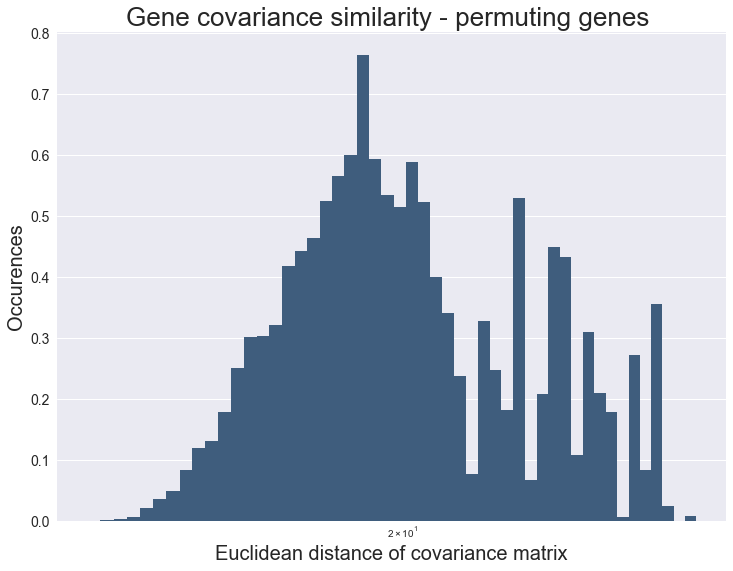

z-score for euclidean distance of non-permuted samples:  2.9236715134147144


In [44]:
dist_cov_euclidean_permute_genes('GO_REGULATION_OF_SYNAPTIC_PLASTICITY.csv', 'AD_Upenn_prot.txt', 'AD_Banner_prot.txt',50000)

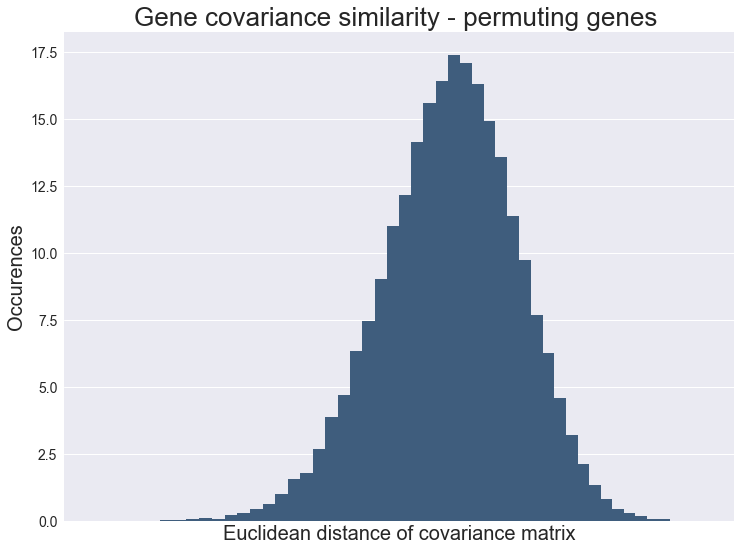

z-score for euclidean distance of non-permuted samples:  -3.6371174962599353


In [45]:
dist_spear_euclidean_permute_genes('GO_REGULATION_OF_SYNAPTIC_PLASTICITY.csv', 'AD_Upenn_prot.txt', 'AD_Banner_prot.txt',50000)

In [20]:
# Function permutes genes and computes euclidean distance distribution of covariance matrix

# comparison_genes: gene set list we want to compare our actual datasets to 
    ## since we are permuting genes anyways, this is only used to create a "True" euclidean distance value that we would 
    ## obtain had no genes been permuted
# dataset1 : samples x gene dataset. should be in txt format

# dataset2: samples x gene dataset. should be in txt format

# permute_number: number of times we want to permute genes (excluding first run without permutations). 
        ## note that the first run is done without any permutations and by taking the intersection of dataset and the 
        ## comparison_genes set

def dist_cov_euclidean_permute_genes(comparison_genes, dataset1, dataset2, permute_number):
    
    # placing datasets into a dataframe
    dataset1_df = pd.read_table(dataset1,index_col=0)  # first dataset for comparison
    dataset2_df = pd.read_table(dataset2,index_col=0)  # second dataset for comparison
    
    # placing comparison genes into a list of lists (just the way it's read in) -- assumes .csv format 
    with open(comparison_genes, 'r') as f:
        reader = csv.reader(f)
        gene_list_raw = list(reader)
            
    # creating list of comparison genes
    gene_list_original = []
    for gene in gene_list_raw:
        gene_list_original.append(gene[0])
        
    # list where euclidean distances will be stored
    euclidean_distances_genes_permute = []

    # creating list of genes without any associated NaN or 0 values 
    # replacing 0s with NaN and then dropping columns with NaN
    dataset1_gene_list_permute = list(dataset1_df.replace(0,pd.np.nan).dropna(axis='columns').columns.values)
    dataset2_gene_list_permute = list(dataset2_df.replace(0,pd.np.nan).dropna(axis='columns').columns.values)
     
    # do one run for the original (i.e., non-permuted) data set; do 'permute_number' of runs with permutations
    for index in range(0,permute_number + 1):

        # finding intersection of genes (i.e., genes in both data set) so that we can obtain permuted list
        # for first run, we will not permute and use genes from the 'comparison_genes' list
        if index > 0:
            genes_to_permute = set(dataset1_gene_list_permute).intersection(dataset2_gene_list_permute)
            gene_set = random.sample(genes_to_permute, num_gene_samples) # number of permuted genes taken depends on the length of genes in intersection of non-permuted dataset       
        else :
            # gene list without permutations
            gene_set = list(set(gene_list_original).intersection(dataset1_gene_list_permute, dataset2_gene_list_permute))
            # number of genes in intersection of all three datasets; will dictate how many permuted genes are taken 
            num_gene_samples = len(gene_set)

        # creating new dataframes that only contains randomly selected genes --- transposing here too
        # first run genes not random
        dataset1_gene_intersect_permuted_T_df = dataset1_df[gene_set].transpose()
        dataset2_gene_intersect_permuted_T_df = dataset2_df[gene_set].transpose()

        # calculating covariance matrices
        dataset1_cov_df = np.cov(dataset1_gene_intersect_permuted_T_df)
        dataset2_cov_df = np.cov(dataset2_gene_intersect_permuted_T_df)

        # calulating norm
        euclidean_norm_new = np.linalg.norm(dataset1_cov_df - dataset2_cov_df)

        # appending calculated norm to list
        euclidean_distances_genes_permute.append(euclidean_norm_new)
                
        # for first run, store euclidean distance in an additional variable (in case list not ordered for some reason)
        if index == 0:
            euclidean_norm_original = euclidean_norm_new

    # plotting histogram
    num_bins = 50 # number of bins
    
    # creating histogram figure object
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)

    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 

    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14) 

    plt.xlabel("Euclidean distance of covariance matrix", fontsize=20)  
    plt.ylabel("Occurences", fontsize=20)

    plt.title('Gene covariance similarity - permuting genes ', fontsize=26)
    plt.xscale('log')


    # histogram of the data
    n, bins, patches = ax.hist(np.log10(euclidean_distances_genes_permute), 50, density=1,color="#3F5D7D")

#     # adding'best fit' line
#     sigma = np.std(euclidean_distances_genes_permute) # standard deviation
#     mu = np.mean(euclidean_distances_genes_permute) # mean
                            
#     y = ((1 / (np.sqrt(2 * np.pi) * sigma )) *
#          np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#     ax.plot(bins, y, '--',color = '#000000')

    # creating vertical line showing where original data lies on distribution
#     plt.axvline(euclidean_norm_original, color='r', linestyle='-', linewidth=2)

#     fig.tight_layout()
    plt.show()

    # z-score for original norm vs norm after permuting genes
    z_score = (euclidean_norm_original - np.mean(euclidean_distances_genes_permute)) / np.std(euclidean_distances_genes_permute)
    print('z-score for euclidean distance of non-permuted samples: ', z_score)

In [41]:
# Function permutes genes and computes euclidean distance distribution of covariance matrix

# comparison_genes: gene set list we want to compare our actual datasets to 
    ## since we are permuting genes anyways, this is only used to create a "True" euclidean distance value that we would 
    ## obtain had no genes been permuted
# dataset1 : samples x gene dataset. should be in txt format

# dataset2: samples x gene dataset. should be in txt format

# permute_number: number of times we want to permute genes (excluding first run without permutations). 
        ## note that the first run is done without any permutations and by taking the intersection of dataset and the 
        ## comparison_genes set

def dist_spear_euclidean_permute_genes(comparison_genes, dataset1, dataset2, permute_number):
    
    # placing datasets into a dataframe
    dataset1_df = pd.read_table(dataset1,index_col=0)  # first dataset for comparison
    dataset2_df = pd.read_table(dataset2,index_col=0)  # second dataset for comparison
    
    # placing comparison genes into a list of lists (just the way it's read in) -- assumes .csv format 
    with open(comparison_genes, 'r') as f:
        reader = csv.reader(f)
        gene_list_raw = list(reader)
            
    # creating list of comparison genes
    gene_list_original = []
    for gene in gene_list_raw:
        gene_list_original.append(gene[0])
        
    # list where euclidean distances will be stored
    euclidean_distances_genes_permute = []

    # creating list of genes without any associated NaN or 0 values 
    # replacing 0s with NaN and then dropping columns with NaN
    dataset1_gene_list_permute = list(dataset1_df.replace(0,pd.np.nan).dropna(axis='columns').columns.values)
    dataset2_gene_list_permute = list(dataset2_df.replace(0,pd.np.nan).dropna(axis='columns').columns.values)
     
    # do one run for the original (i.e., non-permuted) data set; do 'permute_number' of runs with permutations
    for index in range(0,permute_number + 1):

        # finding intersection of genes (i.e., genes in both data set) so that we can obtain permuted list
        # for first run, we will not permute and use genes from the 'comparison_genes' list
        if index > 0:
            genes_to_permute = set(dataset1_gene_list_permute).intersection(dataset2_gene_list_permute)
            gene_set = random.sample(genes_to_permute, num_gene_samples) # number of permuted genes taken depends on the length of genes in intersection of non-permuted dataset       
        else :
            # gene list without permutations
            gene_set = list(set(gene_list_original).intersection(dataset1_gene_list_permute, dataset2_gene_list_permute))
            # number of genes in intersection of all three datasets; will dictate how many permuted genes are taken 
            num_gene_samples = len(gene_set)

        # creating new dataframes that only contains randomly selected genes --- transposing here too
        # first run genes not random
        dataset1_gene_intersect_permuted_df = dataset1_df[gene_set]
        dataset2_gene_intersect_permuted_df = dataset2_df[gene_set]

        # calculating covariance matrices
        dataset1_spear_df = dataset1_gene_intersect_permuted_df.corr(method = 'spearman')
        dataset2_spear_df = dataset2_gene_intersect_permuted_df.corr(method = 'spearman')

        # calulating norm
        euclidean_norm_new = np.linalg.norm(dataset1_spear_df - dataset2_spear_df)

        # appending calculated norm to list
        euclidean_distances_genes_permute.append(euclidean_norm_new)
                
        # for first run, store euclidean distance in an additional variable (in case list not ordered for some reason)
        if index == 0:
            euclidean_norm_original = euclidean_norm_new

    # plotting histogram
    num_bins = 50 # number of bins
    
    # creating histogram figure object
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)

    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 

    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14) 

    plt.xlabel("Euclidean distance of covariance matrix", fontsize=20)  
    plt.ylabel("Occurences", fontsize=20)

    plt.title('Gene covariance similarity - permuting genes ', fontsize=26)
    plt.xscale('log')


    # histogram of the data
    n, bins, patches = ax.hist(np.log10(euclidean_distances_genes_permute), 50, density=1,color="#3F5D7D")

#     # adding'best fit' line
#     sigma = np.std(euclidean_distances_genes_permute) # standard deviation
#     mu = np.mean(euclidean_distances_genes_permute) # mean
                            
#     y = ((1 / (np.sqrt(2 * np.pi) * sigma )) *
#          np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#     ax.plot(bins, y, '--',color = '#000000')

    # creating vertical line showing where original data lies on distribution
#     plt.axvline(euclidean_norm_original, color='r', linestyle='-', linewidth=2)

#     fig.tight_layout()
    plt.show()

    # z-score for original norm vs norm after permuting genes
    z_score = (euclidean_norm_original - np.mean(euclidean_distances_genes_permute)) / np.std(euclidean_distances_genes_permute)
    print('z-score for euclidean distance of non-permuted samples: ', z_score)